## Data Analytics in P-Card ##

### Objective ##

Due to the large volume of transactions and lack of dedicated resources, Accounting relies on P-Card holders and district P-Card Coordinators to identify, track and resolve P-Card disputes. To address this challenge, IA utilizes data analytics methodologies to develop a model that can automatically identify vendor names, cities and states. By implementing this model, the Accounting department can determine whether P-Card holders are in compliance with P-Card policies and procedures.

### Pre-Processing ###

### step1: import all required libraries ###

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None, 'display.max_colwidth', None, 'display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import string
string.punctuation
import re

# importing sys
import sys
# adding Folder_2/subfolder to the system path
sys.path.insert(0, r'S:\AUDIT\Audit\12. Applications\1. Pcard App\Library Files')
from data_cleaner import pcard_columns_tweaker
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

### step2: read in and clean the data ###

In [2]:
# clean the column labels
@pcard_columns_tweaker # set parameters for cleaning column labels
def pcard_normal_tweaker(df):
    """
    cleans the column labels for the vendor file
    """
    
    return df

# clean the pcard spend file
@pcard_columns_tweaker
def pcard_spend_tweaker(_df:pd.DataFrame) -> pd.DataFrame: 
    """
    cleans the column labels for the pcard spend file
    """
    
    return (_df
            .iloc[:, 2:10]
            .dropna(subset=['Employee ID'])
            .drop_duplicates(subset=['Employee ID'], keep='first')
            .astype({
                'Employee ID':int, 
                'Open Date':'datetime64[ns]', 
                'Credit Limit':int
                    })
            .assign(final_four = lambda df: df['Card Number'].str[-4:], 
                    f_name = lambda df: df['First Name'].str.lower(),
                    l_name = lambda df: df['Last Name'].str.lower(),
                    f_name_card = lambda df: df.f_name + df.final_four
                   )
           )

# manipulates the file  
def pcard_trans_df(_df:pd.DataFrame) -> pd.DataFrame:
    """
    manipulates the pcard transaction file
    """
    
    return (_df
            .assign(f_name_card = lambda df: df.acc_account_name.str.split(expand=True)[0].str.lower() + df.acc_account_number.str[-4:])
           )

### step3: combine files ###

In [3]:
# read in the pcard spend file
df_pcard_spend = (pcard_spend_tweaker(
                  pd.read_csv(r"S:\AUDIT\Audit\12. Applications\1. Pcard App\01. Raw Data\MetraCardholder Spend Profile - 09.2023.csv")
                                    ))
# keep only the needed columns 
col_names = ['open_date', 'close_date', 'employee_id', 'f_name', 'l_name', 'mcc_group_type', 'f_name_card']

df_pcard_spend[col_names].head()

,open_date,close_date,employee_id,f_name,l_name,mcc_group_type,f_name_card
0,2006-02-06,,8362,lawrence,weaver,"MET3, MET3A",lawrence0109
1,2008-06-27,,7544,nelson,guitron,"MET3, MET3A",nelson0284
2,2022-12-20,,10738,brian,simmons,MET1,brian0295
3,2017-01-12,,11078,michael,kaderabek,MET1,michael0479
4,2015-02-03,,10483,steven,jones,"MET4, MET4A",steven0510


In [4]:
# read in pcard transaction file
df_pcard_trans = (pcard_normal_tweaker(
                  pd.read_csv(r"S:\AUDIT\Audit\12. Applications\1. Pcard App\01. Raw Data\Transactions Approval whole year 2023.csv")
                                        ))

col_names = ['acc_account_name', 'acc_account_number', 'fin_transaction_date', 
             'fin_transaction_description', 'mch_merchant_name', 'mch_city_name', 
             'mch_state_province', 'mch_country_code', 'mch_merchant_category_code_(mcc)', 
             'fin_transaction_amount', 'gbl_item_description', 'pur_item_description'
            ]

df_pcard_trans = pcard_trans_df(df_pcard_trans[col_names])

In [5]:
print(f'Starting total row count: {len(df_pcard_trans)}')
      
df_pcard_trans_merged = (df_pcard_spend
                         .merge(
                             df_pcard_trans, on='f_name_card', how='right', suffixes=('_left', '_right')
                         ))
print(f'Ending total row count: {len(df_pcard_trans_merged)}')

col_names = ['open_date', 'close_date', 'employee_id', 'mcc_group_type', 'credit_limit', 'acc_account_name', 'acc_account_number',
             'fin_transaction_date', 'fin_transaction_description', 'mch_merchant_name', 'mch_city_name', 'mch_state_province', 
             'mch_city_name', 'mch_state_province', 'mch_country_code', 'mch_merchant_category_code_(mcc)', 'fin_transaction_amount', 
             'gbl_item_description', 'pur_item_description'
            ]

df_pcard_trans_merged[col_names].sample(10)

Starting total row count: 27213
Ending total row count: 27213


,open_date,close_date,employee_id,mcc_group_type,credit_limit,acc_account_name,acc_account_number,fin_transaction_date,fin_transaction_description,mch_merchant_name,mch_city_name,mch_state_province,mch_city_name,mch_state_province,mch_country_code,mch_merchant_category_code_(mcc),fin_transaction_amount,gbl_item_description,pur_item_description
17499,2021-04-02,,6234.0,"MET3, MET3A",3000.0,CURTIS STREETER JR,XXXXXXXX68832010,5/1/2023,THE HOME DEPOT #1950,THE HOME DEPOT #1950,CHICAGO,IL,CHICAGO,IL,USA,5200.0,0,NaN,4X4-12 #2PT
26122,2013-06-14,,7559.0,"MET3, MET3A",3000.0,JOHN L JOHNSTON II,XXXXXXXX23743184,1/17/2023,MENARDS JOLIET IL,MENARDS JOLIET IL,JOLIET,IL,JOLIET,IL,USA,5200.0,0,NaN,"4"" 90DEG ELBOW E04"
4932,2016-09-16,,7953.0,"MET3, MET3A",3000.0,EDGAR VARGAS,XXXXXXXX06259737,10/18/2023,THE HOME DEPOT #6822,THE HOME DEPOT #6822,ALSIP,IL,ALSIP,IL,USA,5200.0,0,NaN,114HGFS1
4445,2021-03-23,,12020.0,"MET14, MET14A",30000.0,LAURA CISNEROS,XXXXXXXX06042359,10/23/2023,AMZN MKTP US*S152H9WM3,AMZN MKTP US*S152H9WM3,AMZN.COM/BILL,WA,AMZN.COM/BILL,WA,USA,5942.0,0,CHRISTMAS LIGHTS BATTERY OPERATED 4 PACK 8 FEET 20 LED STRING LIGHTS ON WHITE WI,NaN
9948,2015-11-16,,10284.0,"MET3, MET3A",3000.0,SAUL CADENAS,XXXXXXXX25013198,8/16/2023,SHERWIN WILLIAMS 70301,SHERWIN WILLIAMS 70301,BERWYN,IL,BERWYN,IL,USA,5231.0,0,NaN,4.5 JUMBO-UF 3-8 2PK
18464,2021-04-15,,11435.0,"MET3, MET3A",3000.0,GREGORY S BRANHAM,XXXXXXXX59595584,4/21/2023,COLONY HARDWARE CORP,COLONY HARDWARE CORP,ORANGE,CT,ORANGE,CT,USA,5072.0,-498.37,NaN,HARDWARE EQUIPMENT
96,2021-09-24,,10254.0,"MET14, MET14A",3000.0,RICHARD SOUKUP IV,XXXXXXXX40641764,12/8/2023,ACE BAKERY LLC,ACE BAKERY LLC,CHICAGO,IL,CHICAGO,IL,USA,5462.0,-263.64,NaN,NaN
11376,2010-09-08,,6565.0,"MET3, MET3A",3000.0,RAYMOND M MONTY,XXXXXXXX22035632,7/27/2023,THE HOME DEPOT #1926,THE HOME DEPOT #1926,DEERFIELD,IL,DEERFIELD,IL,USA,5200.0,0,NaN,HEX BOLT
20355,2021-12-10,,11300.0,"MET3, MET3A",3000.0,NICU C BEZMAN,XXXXXXXX12947978,3/28/2023,THE HOME DEPOT #1936,THE HOME DEPOT #1936,HOMEWOOD,IL,HOMEWOOD,IL,USA,5200.0,0,NaN,WTHRPRF ST
15607,2018-03-09,,9128.0,"MET4, MET4A",100000.0,KATRINA L WILBANKS,XXXXXXXX93481514,5/25/2023,MCNICHOLS COMPANY,MCNICHOLS COMPANY,TAMPA,FL,TAMPA,FL,USA,5051.0,0,NaN,SHIPPING AND HANDLING OPEN


In [6]:
# perform prelimentary data assessment
df_pcard_trans_merged.shape

(27213, 24)

In [7]:
df_pcard_trans_merged.dtypes

open_date                           datetime64[ns]
close_date                                  object
employee_id                                float64
last_name                                   object
first_name                                  object
card_number                                 object
mcc_group_type                              object
credit_limit                               float64
final_four                                  object
f_name                                      object
l_name                                      object
f_name_card                                 object
acc_account_name                            object
acc_account_number                          object
fin_transaction_date                        object
fin_transaction_description                 object
mch_merchant_name                           object
mch_city_name                               object
mch_state_province                          object
mch_country_code               

### step4: Model Development ###

In [8]:
# load the training dataset
## training dataset contains meesy vendor name which is "Vendor_Key" and clean labeled vendor name which is "Vendor_Name"
train_df = pd.read_csv("training_vendor_name_final_version.csv")
train_df.shape

(30198, 3)

In [9]:
# create a function to clean "Vendor_Key"
def clean_text(text):
    text = str(text)  # Convert to string
    return (text
            .lower()  # Convert to lowercase
            .translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
            .strip()  # Remove leading and trailing spaces
            )

# apply the cleaning function to the 'Vendor_Key' column
train_df['Vendor_Key'] = train_df['Vendor_Key'].apply(clean_text)

In [10]:
# create a new dataframe df1 which ensure the original df is not affected
df1 = train_df.copy()

# encode the 'Vendor_Name' column into numerical labels
label_encoder = LabelEncoder()
df1['Vendor_Name_Labels'] = label_encoder.fit_transform(df1['Vendor_Name'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df1['Vendor_Key'], df1['Vendor_Name_Labels'], test_size=0.2, random_state=12272023
)

# create a pipeline with TF-IDF Vectorization and RandomForestClassifier
## n_estimators by using 50,100 and 300, the results are no significant change. Choosing n_estimators = 100 as an optimal model.
model = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100)
)


# insert time count function to track how long this model run
start_time = time.time()

# train the model with the training dataset
model.fit(X_train, y_train)

# stop timing and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time for training and prediction: {elapsed_time:.2f} seconds")

# predict labels for the testing set
y_pred = model.predict(X_test)

# generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

accuracy = report['accuracy']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1_score = report['macro avg']['f1-score']
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1_score = report['weighted avg']['f1-score']

print(f'    accuracy: {accuracy:.2f}')
print(f'   macro avg: {macro_precision:.2f} {macro_recall:.2f} {macro_f1_score:.2f}')
print(f'weighted avg: {weighted_precision:.2f} {weighted_recall:.2f} {weighted_f1_score:.2f}')

Elapsed time for training and prediction: 80.57 seconds
    accuracy: 0.91
   macro avg: 0.41 0.44 0.42
weighted avg: 0.90 0.91 0.90


add explinations of above concepts

### Step5: Predict Vendor Name ###

In [11]:
# predict the Vendor_Name for a new Vendor_Key
def predict_vendor_name(new_vendor_key):
    # apply the same preprocessing to the new vendor key
    new_vendor_key = new_vendor_key.lower()  
    # predict the class (label) for the new vendor key
    predicted_label = model.predict([new_vendor_key])[0]
    # convert the predicted label back to the original class name
    predicted_name = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_name

# randomly input messy vendor name for testing
new_key = "l-com"
predicted_name = predict_vendor_name(new_key)
print(f"The predicted vendor name for '{new_key}' is: {predicted_name}")

The predicted vendor name for 'l-com' is: l-com


### Step6: Apply the Model to previous combined data frame (step3's) ###

In [12]:
# create a new dataframe df2 which ensure the original df and model are not affected
df2 = df_pcard_trans_merged.copy()
df2['mch_merchant_name'] = df2['mch_merchant_name'].apply(clean_text)

In [13]:
# apply model into df2
## predict the clean vendor names
start_time = time.time()
predicted_labels = model.predict(df2['mch_merchant_name'])
elapsed_time = time.time() - start_time
print(f"Prediction time: {elapsed_time:.2f} seconds")

# convert the numerical labels back to vendor names
predicted_vendor_names = label_encoder.inverse_transform(predicted_labels)

# add the predictions to df2
df2['predicted_Vendor_Name'] = predicted_vendor_names

Prediction time: 40.04 seconds


## Step 7: Evalulate developed model on new data ##

In [14]:
# transform new data using the TF-IDF vectorizer 
tfidf_transformer = model.named_steps['tfidfvectorizer']
X_train_tfidf = tfidf_transformer.transform(X_train)  
df2_tfidf = tfidf_transformer.transform(df2['mch_merchant_name'])

cosine_sim_scores_df2 = cosine_similarity(df2_tfidf, X_train_tfidf)

# store maximum cosine similarity scores for each vendor name
max_cosine_sim_scores_df2 = cosine_sim_scores_df2.max(axis=1)
df2['Cosine_Similarity_Score'] = max_cosine_sim_scores_df2

# check for average cosine similarity scores also
average_cosine_similarity_df2 = np.mean(max_cosine_sim_scores_df2)
print(f"Average Cosine Similarity Score for df2: {average_cosine_similarity_df2:.2f}")

Average Cosine Similarity Score for df2: 0.99


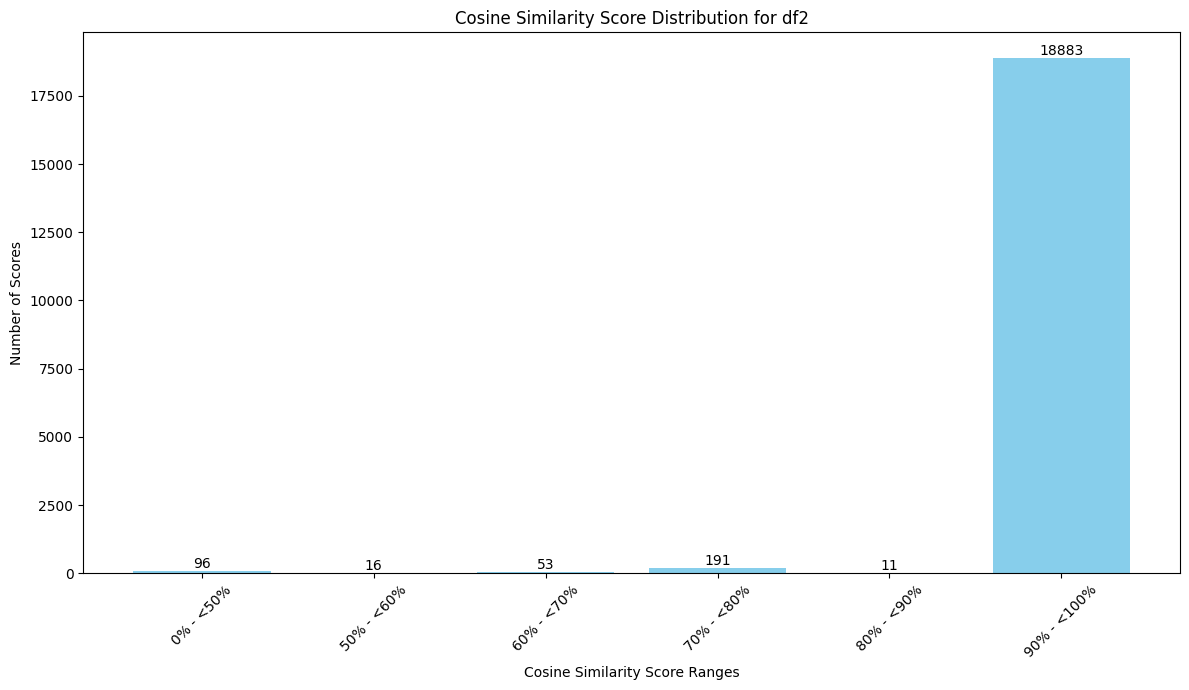

In [15]:
max_cosine_sim_scores_df2 = df2['Cosine_Similarity_Score'].values

# set thresholds
thresholds = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
counts = []

# calculate counts for each range
for i in range(len(thresholds) - 1):
    low = thresholds[i]
    high = thresholds[i + 1]
    if i == 0:
        # include scores that are exactly 0.0
        count = ((max_cosine_sim_scores_df2 >= low) & (max_cosine_sim_scores_df2 < high)).sum()
    else:
        # Exclude the lower bound
        count = ((max_cosine_sim_scores_df2 > low) & (max_cosine_sim_scores_df2 <= high)).sum()
    counts.append(count)

# labels for the ranges
labels = [f"{int(low*100)}% - <{int(high*100)}%" for low, high in zip(thresholds[:-1], thresholds[1:])]

# plotting
plt.figure(figsize=(12, 7))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Cosine Similarity Score Ranges')
plt.ylabel('Number of Scores')
plt.title('Cosine Similarity Score Distribution for df2')
plt.xticks(rotation=45)

# adding data labels
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()